## Load Libraries and Dataset

In [1]:
import random
import numpy as np
import pandas as pd
import collections
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import Lasso
from statistics import mean, variance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error

# Load test and train set
train_set = pd.read_csv('/Users/andylenguyen/Documents/PYTHON/COMP30027/A2/train_dataset.csv');       
test_set = pd.read_csv('/Users/andylenguyen/Documents/PYTHON/COMP30027/A2/test_dataset.csv')

In [2]:
train_set.columns

Index(['id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes',
       'title_embedding', 'average_degree_centrality', 'imdb_score_binned'],
      dtype='object')

# Data Preprocessing

## 1. Feature Selection Phase 1: Drop non-informative features

### Using Correlation 

In [3]:
train_set.drop(columns=['id'], inplace=True)

/var/folders/wj/h_1007j11234tm_jw14krlgw0000gn/T/ipykernel_83205/2007676717.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=imdb_score_correlations.values, y=imdb_score_correlations.index, palette='viridis')


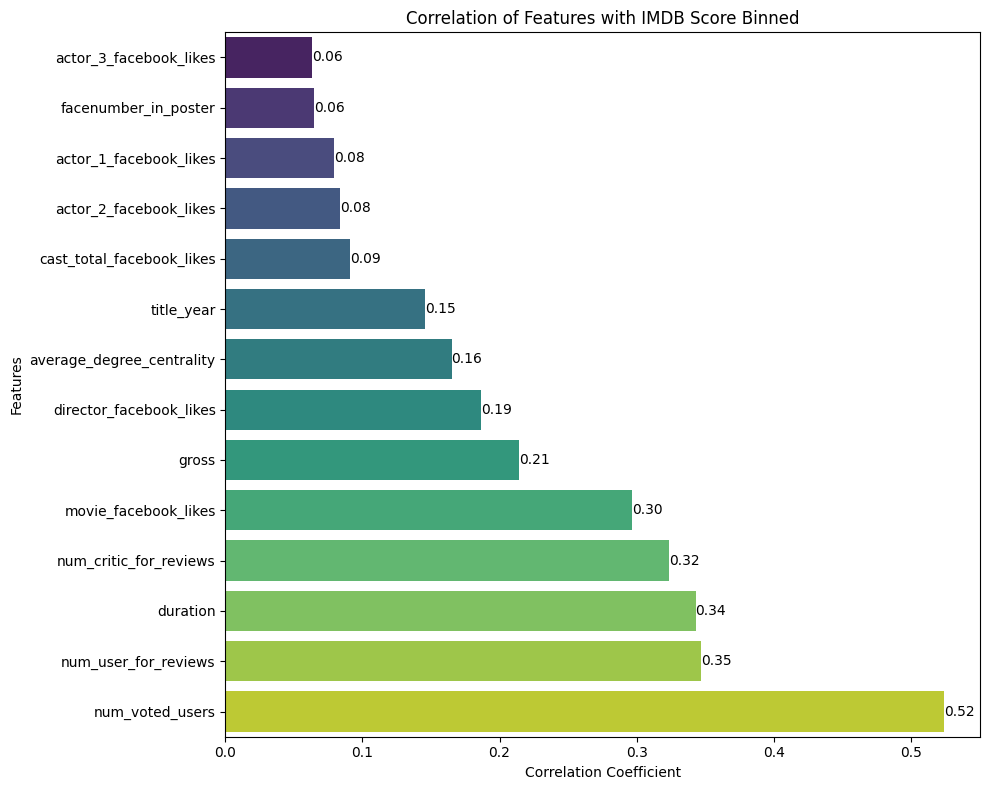

In [4]:
non_object_columns = train_set.select_dtypes(exclude=['object'])

corr_matrix = abs(non_object_columns.corr())

imdb_score_correlations = corr_matrix['imdb_score_binned']

# Drop self-correlation 
imdb_score_correlations = imdb_score_correlations.drop('imdb_score_binned')

# Sort the values for better visualization
imdb_score_correlations = imdb_score_correlations.sort_values()

# Plotting
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x=imdb_score_correlations.values, y=imdb_score_correlations.index, palette='viridis')
for index, value in enumerate(imdb_score_correlations):
    plt.text(value, index, f'{value:.2f}', color='black', va='center')

plt.title('Correlation of Features with IMDB Score Binned')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [5]:
# Drop those features under threshold < 0.1
train_set.drop(columns=['facenumber_in_poster','actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes'], inplace=True)

In [6]:
train_set.drop(columns=['title_embedding', 'plot_keywords'], inplace=True)

### Inspect categorical columns

In [7]:
object_columns = train_set.columns[train_set.dtypes == 'object']
object_columns

Index(['director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'movie_title', 'actor_3_name', 'language', 'country', 'content_rating'],
      dtype='object')

## 2. Convert Categorical Features to Numerical

### Genres column

In [8]:
movie_genres = train_set['genres']

In [9]:
genres = []

for i in range(len(movie_genres)):
  genres += movie_genres[i].split('|')

genres_list = list(set(genres))
genres_list

['Drama',
 'Biography',
 'History',
 'Sport',
 'Crime',
 'Animation',
 'Sci-Fi',
 'Comedy',
 'Fantasy',
 'Mystery',
 'Thriller',
 'Romance',
 'Music',
 'Horror',
 'Western',
 'Documentary',
 'Action',
 'Musical',
 'Adventure',
 'Film-Noir',
 'Family',
 'War']

In [10]:
print("The total number of different genres:", len(genres_list))

The total number of different genres: 22


In [11]:
movie_genres_dict = {}

for i in genres_list:
  movie_genres_dict[i] = []

for element in movie_genres:
  arr = list(set(element.split('|')))

  for key in movie_genres_dict:

    if key in arr:
     movie_genres_dict[key].append(1)
    else:
      movie_genres_dict[key].append(0)

In [12]:
df_movie_genres = pd.DataFrame(data = movie_genres_dict)
df_movie_genres.head()

,Drama,Biography,History,Sport,Crime,Animation,Sci-Fi,Comedy,Fantasy,Mystery,...,Music,Horror,Western,Documentary,Action,Musical,Adventure,Film-Noir,Family,War
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [13]:
train_set = pd.concat([df_movie_genres, train_set.drop('genres', axis = 1)], axis = 1)

In [14]:
train_set #inspect

,Drama,Biography,History,Sport,Crime,Animation,Sci-Fi,Comedy,Fantasy,Mystery,...,num_voted_users,actor_3_name,num_user_for_reviews,language,country,content_rating,title_year,movie_facebook_likes,average_degree_centrality,imdb_score_binned
0,1,0,0,0,0,1,0,0,0,0,...,644348,Niketa Calame,656,English,USA,G,1994,17000,0.001576,4
1,0,0,0,0,0,0,0,0,0,0,...,78883,Pedro Miguel Arce,662,English,Canada,R,2005,0,0.000675,2
2,1,0,0,0,0,0,0,0,0,0,...,36494,Ronnie Gene Blevins,118,English,USA,R,2013,11000,0.003002,2
3,0,0,0,0,0,0,1,0,0,1,...,258078,David Clennon,911,English,USA,R,1982,23000,0.001726,4
4,1,0,0,0,0,0,0,0,1,0,...,1238746,Billy Boyd,5060,English,New Zealand,PG-13,2001,21000,0.001876,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,1,0,0,0,0,0,0,1,0,0,...,132048,Sachiko Ishida,203,English,USA,PG-13,2009,12000,0.000750,2
3000,1,1,0,1,0,0,0,0,0,0,...,312629,Alexandra Maria Lara,475,English,UK,R,2013,83000,0.003302,4
3001,1,0,0,0,1,0,0,0,0,0,...,217480,Michael Kelly,429,English,USA,R,2009,21000,0.003302,3
3002,1,0,0,0,0,0,0,1,0,0,...,9750,Nadine Labaki,66,Arabic,France,PG,2007,0,0.000300,3


### Content Rating Column

In [15]:
train_set['content_rating'].value_counts()

content_rating
R            1362
PG-13        1039
PG            458
G              68
Not Rated      27
Unrated        19
Approved       14
X               9
NC-17           3
M               2
Passed          2
GP              1
Name: count, dtype: int64

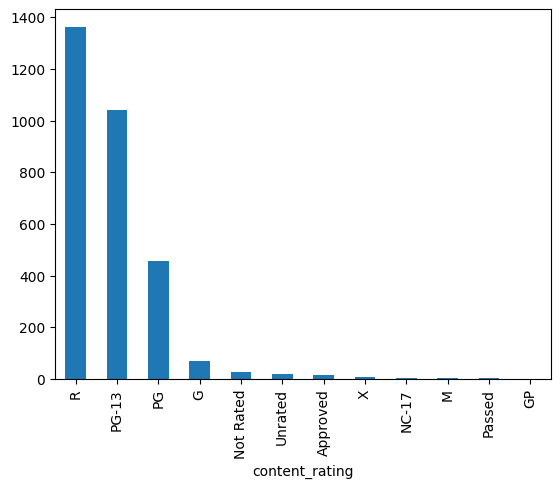

In [16]:
train_set['content_rating'].value_counts().plot(kind = 'bar')
plt.show()

In [17]:
train_set = pd.concat([pd.get_dummies(train_set['content_rating'])[['R','PG-13','PG','G']].astype(int), train_set.drop('content_rating', axis = 1)], axis = 1)


In [18]:
train_set

,R,PG-13,PG,G,Drama,Biography,History,Sport,Crime,Animation,...,movie_title,num_voted_users,actor_3_name,num_user_for_reviews,language,country,title_year,movie_facebook_likes,average_degree_centrality,imdb_score_binned
0,0,0,0,1,1,0,0,0,0,1,...,The Lion King,644348,Niketa Calame,656,English,USA,1994,17000,0.001576,4
1,1,0,0,0,0,0,0,0,0,0,...,Land of the Dead,78883,Pedro Miguel Arce,662,English,Canada,2005,0,0.000675,2
2,1,0,0,0,1,0,0,0,0,0,...,Joe,36494,Ronnie Gene Blevins,118,English,USA,2013,11000,0.003002,2
3,1,0,0,0,0,0,0,0,0,0,...,The Thing,258078,David Clennon,911,English,USA,1982,23000,0.001726,4
4,0,1,0,0,1,0,0,0,0,0,...,The Lord of the Rings: The Fellowship of the R...,1238746,Billy Boyd,5060,English,New Zealand,2001,21000,0.001876,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,0,1,0,0,1,0,0,0,0,0,...,He's Just Not That Into You,132048,Sachiko Ishida,203,English,USA,2009,12000,0.000750,2
3000,1,0,0,0,1,1,0,1,0,0,...,Rush,312629,Alexandra Maria Lara,475,English,UK,2013,83000,0.003302,4
3001,1,0,0,0,1,0,0,0,1,0,...,Law Abiding Citizen,217480,Michael Kelly,429,English,USA,2009,21000,0.003302,3
3002,0,0,1,0,1,0,0,0,0,0,...,Caramel,9750,Nadine Labaki,66,Arabic,France,2007,0,0.000300,3


### Language Column

In [19]:
train_set['language'].value_counts()

language
English       2872
French          32
Spanish         19
Mandarin         9
Japanese         9
German           9
Italian          5
Cantonese        5
Korean           4
Portuguese       4
Hindi            3
Norwegian        3
Dutch            3
Danish           3
Aboriginal       2
Thai             2
Indonesian       2
Dari             2
Persian          2
Kazakh           1
Maya             1
Aramaic          1
Filipino         1
Bosnian          1
Czech            1
Zulu             1
Vietnamese       1
Hungarian        1
Hebrew           1
Mongolian        1
Romanian         1
Arabic           1
Name: count, dtype: int64

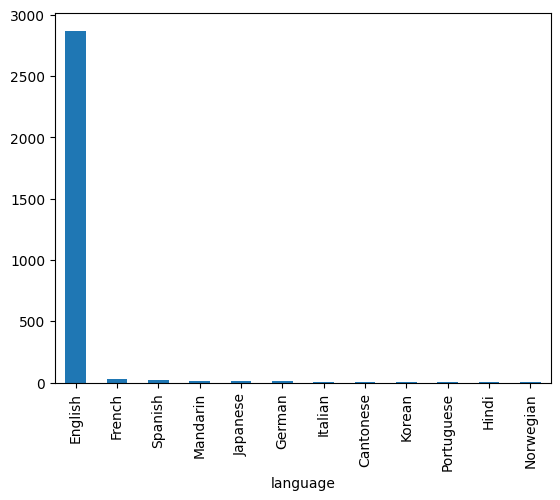

In [20]:
train_set['language'].value_counts().head(12).plot(kind = 'bar')
plt.show()

Since the number of instances with language: "English" takes dominant, we removed it (non-informative)

In [21]:
train_set.drop(columns = ['language'], inplace = True )

### Country column

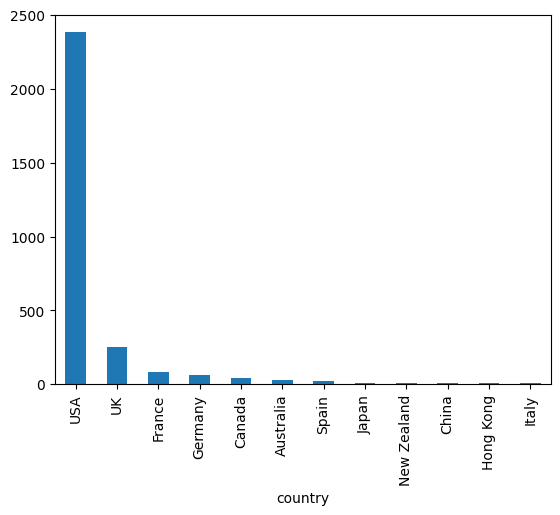

In [22]:
train_set['country'].value_counts()

train_set['country'].value_counts().head(12).plot(kind = 'bar')
plt.show()

In [23]:
train_set = pd.concat([pd.get_dummies(train_set['country'])[['USA','UK','France','Germany']].astype(int), train_set.drop('country', axis = 1)], axis = 1)

### All other columns (director_name, actor_1_name, actor_2_name, actor_3_name, movie_title)

In [24]:
train_set.drop(columns = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name'], inplace = True )
train_set.drop(columns = ['movie_title'], inplace = True )
train_set.columns

Index(['USA', 'UK', 'France', 'Germany', 'R', 'PG-13', 'PG', 'G', 'Drama',
       'Biography', 'History', 'Sport', 'Crime', 'Animation', 'Sci-Fi',
       'Comedy', 'Fantasy', 'Mystery', 'Thriller', 'Romance', 'Music',
       'Horror', 'Western', 'Documentary', 'Action', 'Musical', 'Adventure',
       'Film-Noir', 'Family', 'War', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'gross', 'num_voted_users',
       'num_user_for_reviews', 'title_year', 'movie_facebook_likes',
       'average_degree_centrality', 'imdb_score_binned'],
      dtype='object')

## 3. Inspect missing value 
None missing value

In [25]:
train_set.isna().sum()

USA                          0
UK                           0
France                       0
Germany                      0
R                            0
PG-13                        0
PG                           0
G                            0
Drama                        0
Biography                    0
History                      0
Sport                        0
Crime                        0
Animation                    0
Sci-Fi                       0
Comedy                       0
Fantasy                      0
Mystery                      0
Thriller                     0
Romance                      0
Music                        0
Horror                       0
Western                      0
Documentary                  0
Action                       0
Musical                      0
Adventure                    0
Film-Noir                    0
Family                       0
War                          0
num_critic_for_reviews       0
duration                     0
director

## 4. Standardise

In [26]:
'''Plot the orginal numerical feature to see skewness'''
origin_num_cols = ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'gross', 'num_voted_users', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes', 'average_degree_centrality']
origin_num_set = train_set[origin_num_cols]
origin_num_set

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,num_user_for_reviews,title_year,movie_facebook_likes,average_degree_centrality
0,186,73,28,422783777,644348,656,1994,17000,0.001576
1,252,97,0,20433940,78883,662,2005,0,0.000675
2,232,117,234,371897,36494,118,2013,11000,0.003002
3,297,109,0,13782838,258078,911,1982,23000,0.001726
4,297,171,0,313837577,1238746,5060,2001,21000,0.001876
...,...,...,...,...,...,...,...,...,...
2999,161,129,42,93952276,132048,203,2009,12000,0.000750
3000,393,123,2000,26903709,312629,475,2013,83000,0.003302
3001,216,118,473,73343413,217480,429,2009,21000,0.003302
3002,109,95,0,1060591,9750,66,2007,0,0.000300


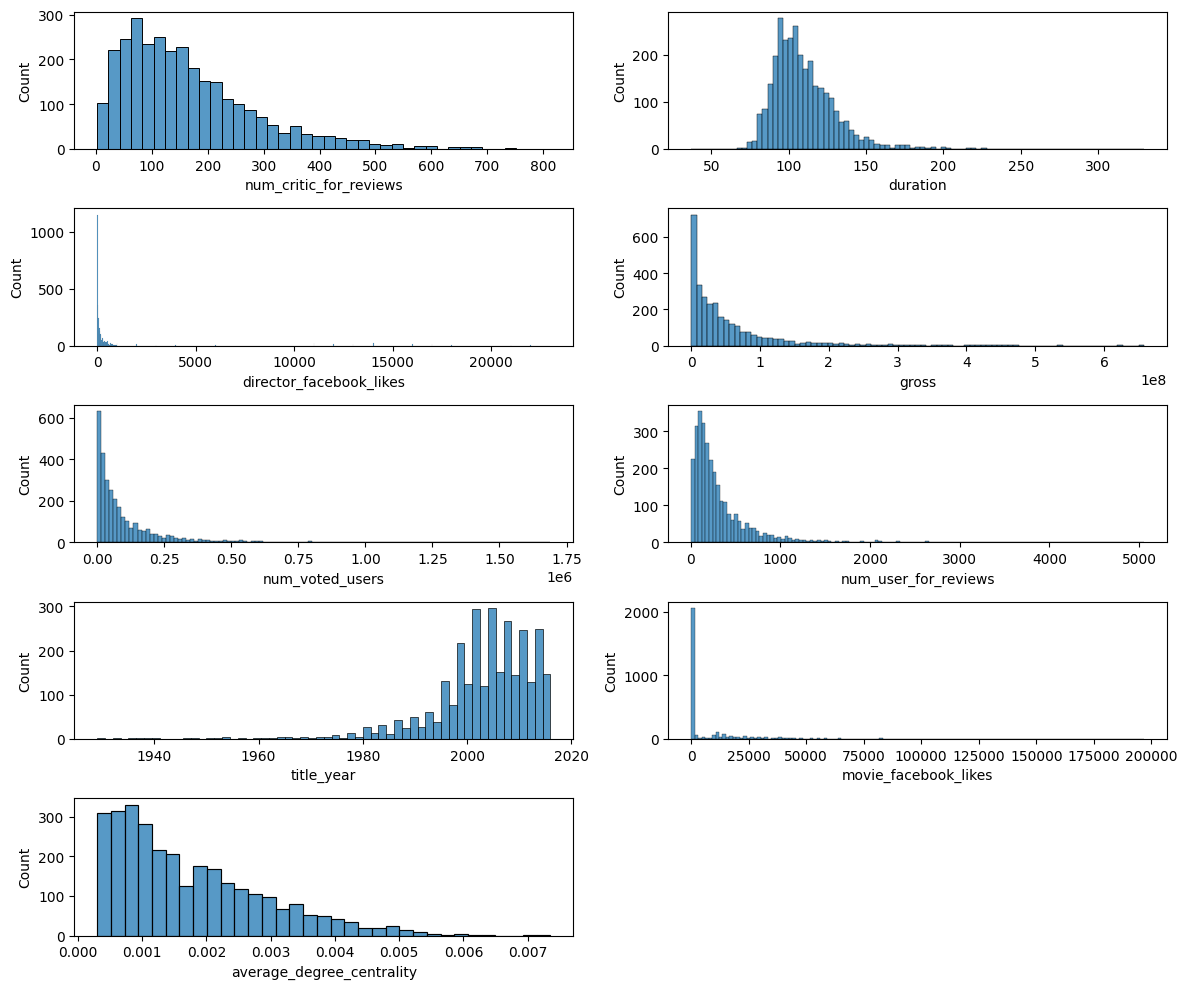

In [27]:
rows = 5
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 10))
col = origin_num_set.columns
index = 0

for i in range(rows):
    for j in range(cols):
        if index < len(col): 
            sns.histplot(train_set[col[index]], ax=ax[i][j])
            index += 1
        else:
            ax[i][j].axis('off')  
plt.tight_layout()
plt.show()

In [28]:
'''Standardise'''
scaler = StandardScaler()
y = train_set['imdb_score_binned']
X = train_set.drop(columns=['imdb_score_binned'])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.join(train_set['imdb_score_binned'])
joblib.dump(scaler, 'standardise_scaler.pkl')

['standardise_scaler.pkl']

## 5. Feature Selection

In [29]:
''' Feature Selection '''
# LASSO
lasso = Lasso(alpha=0.02)
lasso.fit(X, y)
selected_features_scaled = [X.columns[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
print("Selected features after scaling using LASSO regression:", selected_features_scaled)
len(selected_features_scaled)


Selected features after scaling using LASSO regression: ['USA', 'Germany', 'R', 'PG-13', 'Drama', 'Biography', 'History', 'Animation', 'Sci-Fi', 'Comedy', 'Fantasy', 'Thriller', 'Horror', 'Documentary', 'Action', 'Adventure', 'Family', 'War', 'num_critic_for_reviews', 'duration', 'gross', 'num_voted_users', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes']


25

In [30]:
''' Finally, a new dataset with selected features '''
new_train_set = X[selected_features_scaled]
new_train_set.columns

Index(['USA', 'Germany', 'R', 'PG-13', 'Drama', 'Biography', 'History',
       'Animation', 'Sci-Fi', 'Comedy', 'Fantasy', 'Thriller', 'Horror',
       'Documentary', 'Action', 'Adventure', 'Family', 'War',
       'num_critic_for_reviews', 'duration', 'gross', 'num_voted_users',
       'num_user_for_reviews', 'title_year', 'movie_facebook_likes'],
      dtype='object')

# Model Implemetation

## 1. Reason behind choosing Stratified K-Fold

In [31]:
print('Value of 0:', round(24/len(y) * 100))
print('Value of 1:', round(235/len(y) * 100))
print('Value of 2:', round(1839/len(y) * 100))
print('Value of 3:',round(777/len(y) * 100))
print('Value of 4:', round(129/len(y) * 100))

Value of 0: 1
Value of 1: 8
Value of 2: 61
Value of 3: 26
Value of 4: 4


## 2. K Nearest Neighbour Classifier

### Before Tuning

In [32]:
n_splits = 15

# Initialize Stratified K fold 
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
accuracy = []
# Initialize KNN
neigh = KNeighborsClassifier(n_neighbors=5, p=2)

# Indexes for each split
for train_index, test_index in skf.split(new_train_set, y):
    X_train, X_validate = new_train_set.iloc[train_index], new_train_set.iloc[test_index]
    y_train, y_validate = y.iloc[train_index], y.iloc[test_index]
    
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_validate)
    
    # Accuracy
    acc = accuracy_score(y_validate, y_pred)
    accuracy.append(acc)
    print(f"Accuracy: {acc}")

print(f"Average K-NN Accuracy: {mean(accuracy)}")


Accuracy: 0.7164179104477612
Accuracy: 0.6517412935323383
Accuracy: 0.6467661691542289
Accuracy: 0.681592039800995
Accuracy: 0.665
Accuracy: 0.75
Accuracy: 0.655
Accuracy: 0.68
Accuracy: 0.655
Accuracy: 0.655
Accuracy: 0.675
Accuracy: 0.645
Accuracy: 0.67
Accuracy: 0.67
Accuracy: 0.645
Average K-NN Accuracy: 0.6707678275290215


### Hyperparameter Tuning

In [33]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

# Parameters grid to search
param_grid = {
    'n_neighbors': range(1, 21),  # Number of neighbours
    'weights': ['uniform', 'distance'],  # Weight types
    'p': [1, 2]  # 1: Manhattan Distance, 2: Euclidean Distance
}

# Initialize KNN
neigh = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=neigh, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(new_train_set, y)  

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 15 folds for each of 80 candidates, totalling 1200 fits
Best parameters: {'n_neighbors': 18, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy: 0.7027346600331674


### After Tuning

In [34]:
# Apply new hyperparameter after tuning
neigh = KNeighborsClassifier(n_neighbors=18, p=1, weights='distance')

n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
accuracy = []
precision_list = []
recall_list = []
f1_score_list = []
mse_list = []
conf_matrices = []
y_prob = []
y_val_list = []

# Indexes for each split
for train_index, test_index in skf.split(new_train_set, y):
    X_train, X_validate = new_train_set.iloc[train_index], new_train_set.iloc[test_index]
    y_train, y_validate = y.iloc[train_index], y.iloc[test_index]
    
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_validate)
    y_prob.append(y_pred)
    y_val_list.append(y_validate)

    joblib.dump(neigh, "knn.pkl")
    
    # Accuracy
    acc = accuracy_score(y_validate, y_pred)
    accuracy.append(acc)
    print(f"Accuracy: {acc}")

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_validate, y_pred, average='weighted', zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    
    # Mean Squared Error (for bias calculation)
    mse = mean_squared_error(y_validate, y_pred)
    mse_list.append(mse)

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_validate, y_pred)
    conf_matrices.append(cm)

# Average Metrics
avg_accuracy = mean(accuracy)
avg_precision = mean(precision_list)
avg_recall = mean(recall_list)
avg_f1_score = mean(f1_score_list)
avg_mse = mean(mse_list)

# Variance
variance_accuracy = variance(accuracy)
variance_precision = variance(precision_list)
variance_recall = variance(recall_list)
variance_f1_score = variance(f1_score_list)

# Bias
bias = np.sqrt(avg_mse)
print("-"*20)
print(f"Average K-NN Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance in Accuracy: {variance_accuracy:.4f}")
print(f"Variance in Precision: {variance_precision:.4f}")
print(f"Variance in Recall: {variance_recall:.4f}")
print(f"Variance in F1 Score: {variance_f1_score:.4f}")


Accuracy: 0.7014925373134329
Accuracy: 0.6865671641791045
Accuracy: 0.7064676616915423
Accuracy: 0.7014925373134329
Accuracy: 0.715
Accuracy: 0.77
Accuracy: 0.65
Accuracy: 0.695
Accuracy: 0.68
Accuracy: 0.735
Accuracy: 0.685
Accuracy: 0.705
Accuracy: 0.69
Accuracy: 0.705
Accuracy: 0.715
--------------------
Average K-NN Accuracy: 0.7027
Average Precision: 0.6791
Average Recall: 0.7027
Average F1 Score: 0.6553
Bias: 0.5912
Variance in Accuracy: 0.0007
Variance in Precision: 0.0025
Variance in Recall: 0.0007
Variance in F1 Score: 0.0011


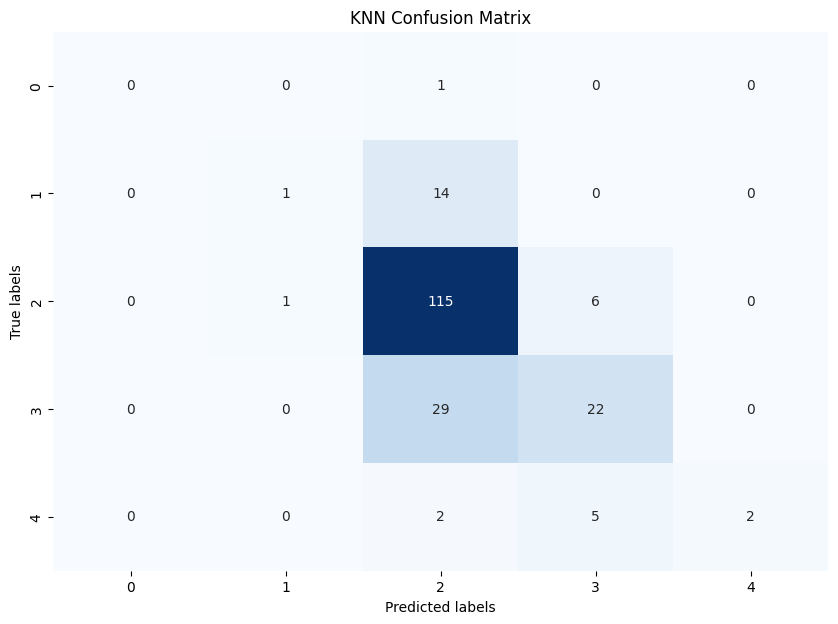

In [35]:
# Calculate the average confusion matrix
mean_cm = np.mean(conf_matrices, axis=0)

# Plotting the average confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(mean_cm, annot=True, fmt=".0f", cmap='Blues', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3. Random Forest Classifier

### Before Tuning

In [37]:
# Initialize Random Forest 
rf_classifier = RandomForestClassifier(random_state=100)

n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

accuracy = []
# Indexes for each split
for train_index, test_index in skf.split(new_train_set, y):
    X_train, X_validate = new_train_set.iloc[train_index], new_train_set.iloc[test_index]
    y_train, y_validate = y.iloc[train_index], y.iloc[test_index]

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_validate)

    print("Accuracy:", accuracy_score(y_validate, y_pred))
    accuracy.append(accuracy_score(y_validate, y_pred))

print("Average Random Forest Accuracy:", mean(accuracy))


Accuracy: 0.7562189054726368
Accuracy: 0.7164179104477612
Accuracy: 0.7313432835820896
Accuracy: 0.7512437810945274
Accuracy: 0.73
Accuracy: 0.765
Accuracy: 0.72
Accuracy: 0.755
Accuracy: 0.715
Accuracy: 0.74
Accuracy: 0.725
Accuracy: 0.735
Accuracy: 0.785
Accuracy: 0.76
Accuracy: 0.76
Average Random Forest Accuracy: 0.7430149253731343


### Hyperparameter Tuning

In [38]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

# param used for randomize search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, 40, 50],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize the classifier
rf_classifier = RandomForestClassifier(random_state=100)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, n_iter=100, cv=skf, scoring='accuracy', verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(new_train_set, y)

# Get the best parameters and the best model
print("Best parameters:", random_search.best_params_)
best_rf_classifier = random_search.best_estimator_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_esti

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
600 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Cross-validated Accuracy: 0.7486716417910447


### After Tuning

In [61]:
# Apply new parameter 
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=15, min_samples_leaf=2, max_features='sqrt', max_depth=50, bootstrap=False, random_state=100)
# Number of splits/folds
n_splits = 15

# Creating the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

accuracy = []
precision_list = []
recall_list = []
f1_score_list = []
mse_list = []
conf_matrices = []
y_prob = []
y_val_list = []

# Indexes for each split
for train_index, test_index in skf.split(new_train_set, y):
    X_train, X_validate = new_train_set.iloc[train_index], new_train_set.iloc[test_index]
    y_train, y_validate = y.iloc[train_index], y.iloc[test_index]

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_validate)
    y_prob.append(y_pred)
    y_val_list.append(y_validate)

    joblib.dump(rf_classifier, "randomforest.pkl")

    # Accuracy
    acc = accuracy_score(y_validate, y_pred)
    accuracy.append(acc)
    print(f"Accuracy: {acc}")

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_validate, y_pred, average='weighted', zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    
    # Mean Squared Error (for bias calculation)
    mse = mean_squared_error(y_validate, y_pred)
    mse_list.append(mse)

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_validate, y_pred)
    conf_matrices.append(cm)

# Average Metrics
avg_accuracy = mean(accuracy)
avg_precision = mean(precision_list)
avg_recall = mean(recall_list)
avg_f1_score = mean(f1_score_list)
avg_mse = mean(mse_list)

# Variance
variance_accuracy = variance(accuracy)
variance_precision = variance(precision_list)
variance_recall = variance(recall_list)
variance_f1_score = variance(f1_score_list)

# Bias (considered as average error)
bias = np.sqrt(avg_mse)
print("-"*20)
print(f"Average Random Forest Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance in Accuracy: {variance_accuracy:.4f}")
print(f"Variance in Precision: {variance_precision:.4f}")
print(f"Variance in Recall: {variance_recall:.4f}")
print(f"Variance in F1 Score: {variance_f1_score:.4f}")


Accuracy: 0.7562189054726368
Accuracy: 0.7263681592039801
Accuracy: 0.746268656716418
Accuracy: 0.7512437810945274
Accuracy: 0.735
Accuracy: 0.79
Accuracy: 0.74
Accuracy: 0.755
Accuracy: 0.69
Accuracy: 0.755
Accuracy: 0.715
Accuracy: 0.745
Accuracy: 0.785
Accuracy: 0.74
Accuracy: 0.76
--------------------
Average Random Forest Accuracy: 0.7460
Average Precision: 0.7303
Average Recall: 0.7460
Average F1 Score: 0.7117
Bias: 0.5316
Variance in Accuracy: 0.0006
Variance in Precision: 0.0016
Variance in Recall: 0.0006
Variance in F1 Score: 0.0006


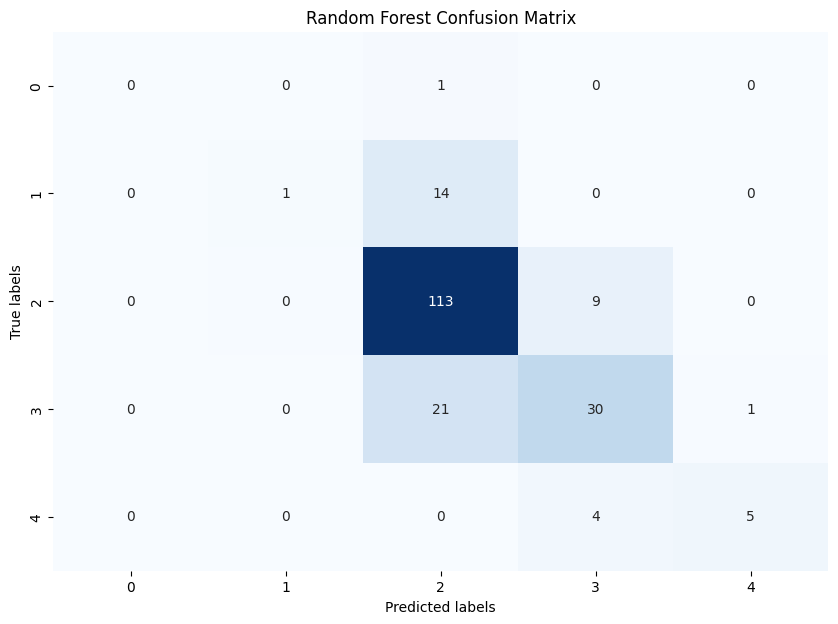

In [62]:
# Calculate the average confusion matrix
mean_cm = np.mean(conf_matrices, axis=0)

# Plotting the average confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(mean_cm, annot=True, fmt=".0f", cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# ------------------------------------------------------------------------

# Perform On Test Data

In [37]:
''' Drop all features drop during phase 1 of training'''
test_id = test_set['id']
test_set.drop(columns=['id', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes', 'plot_keywords', 'title_embedding', 'facenumber_in_poster'], inplace=True)

In [38]:
test_set.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_2_name                 0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
actor_3_name                 0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
title_year                   0
movie_facebook_likes         0
average_degree_centrality    0
dtype: int64

In [39]:
object_columns = test_set.columns[test_set.dtypes == 'object']
object_columns

Index(['director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'movie_title', 'actor_3_name', 'language', 'country', 'content_rating'],
      dtype='object')

## Convert Categorical to Numerical

### Genres column

In [40]:
test_movie_genres = test_set['genres']
genres_test = []

for i in range(len(test_movie_genres)):
  genres_test += test_movie_genres[i].split('|')

test_genres_list = list(set(genres_test))
test_genres_list
print("The total number of different genres:", len(test_genres_list))
test_movie_genres_dict = {}

for i in test_genres_list:
  test_movie_genres_dict[i] = []

for element in test_movie_genres:
  arr = list(set(element.split('|')))

  for key in test_movie_genres_dict:

    if key in arr:
     test_movie_genres_dict[key].append(1)
    else:
      test_movie_genres_dict[key].append(0)

df_test_movie_genres = pd.DataFrame(data = test_movie_genres_dict)

The total number of different genres: 21


In [41]:
test_set = pd.concat([df_test_movie_genres, test_set.drop('genres', axis = 1)], axis = 1)
test_set

,Biography,Drama,History,Sport,Crime,Animation,Comedy,Sci-Fi,Fantasy,Mystery,...,movie_title,num_voted_users,actor_3_name,num_user_for_reviews,language,country,content_rating,title_year,movie_facebook_likes,average_degree_centrality
0,1,1,0,1,0,0,0,0,0,0,...,Courage,2302,Brent Anderson,20,English,USA,PG,2015,0,0.000375
1,0,1,0,0,1,0,0,0,0,0,...,Savages,104301,Gary Stretch,269,English,USA,R,2012,28000,0.002176
2,0,1,0,0,1,0,1,0,0,0,...,Defendor,31836,Charlotte Sullivan,90,English,Canada,R,2009,0,0.000900
3,0,1,0,0,1,0,0,0,0,0,...,Road to Perdition,200359,Liam Aiken,1009,English,USA,R,2002,0,0.003452
4,0,0,0,0,0,0,1,0,0,0,...,The To Do List,29517,Scott Porter,79,English,USA,R,2013,0,0.000450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0,1,0,0,0,0,1,0,0,0,...,Rushmore,134458,Olivia Williams,640,English,USA,R,1998,5000,0.002777
748,0,0,0,0,0,0,0,0,1,0,...,Abraham Lincoln: Vampire Hunter,128629,Benjamin Walker,348,English,USA,R,2012,98000,0.001801
749,0,1,0,0,0,0,0,0,0,0,...,A Room with a View,29610,Denholm Elliott,94,English,UK,Unrated,1985,0,0.001126
750,0,0,0,0,0,1,0,0,0,0,...,The Jungle Book 2,11634,Tony Jay,58,English,USA,G,2003,227,0.000825


### Content Column

In [42]:
test_set['content_rating'].value_counts()

content_rating
R            338
PG-13        269
PG           108
G             19
Not Rated      7
NC-17          3
Approved       3
Unrated        3
X              1
Passed         1
Name: count, dtype: int64

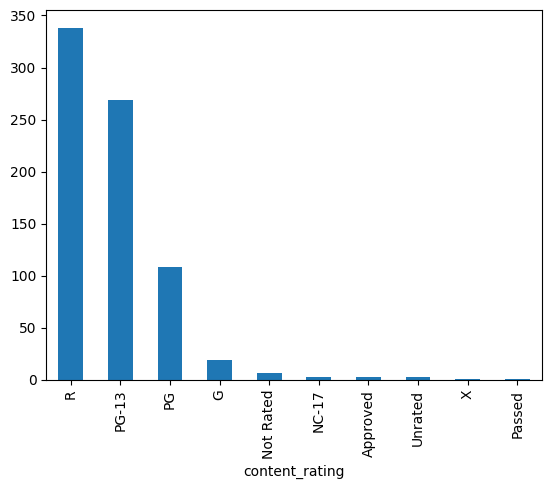

In [43]:
test_set['content_rating'].value_counts().plot(kind = 'bar')
plt.show()

In [44]:
test_set = pd.concat([pd.get_dummies(test_set['content_rating'])[['R','PG-13','PG','G']].astype(int), test_set.drop('content_rating', axis = 1)], axis = 1)

### Language Column

In [45]:
test_set['language'].value_counts()

language
English       726
Mandarin        6
Spanish         4
Italian         2
French          2
Hindi           2
Cantonese       2
Persian         1
Thai            1
Korean          1
German          1
Norwegian       1
Russian         1
Japanese        1
Portuguese      1
Name: count, dtype: int64

In [46]:
test_set.drop(columns = ['language'], inplace = True )

### Country Column

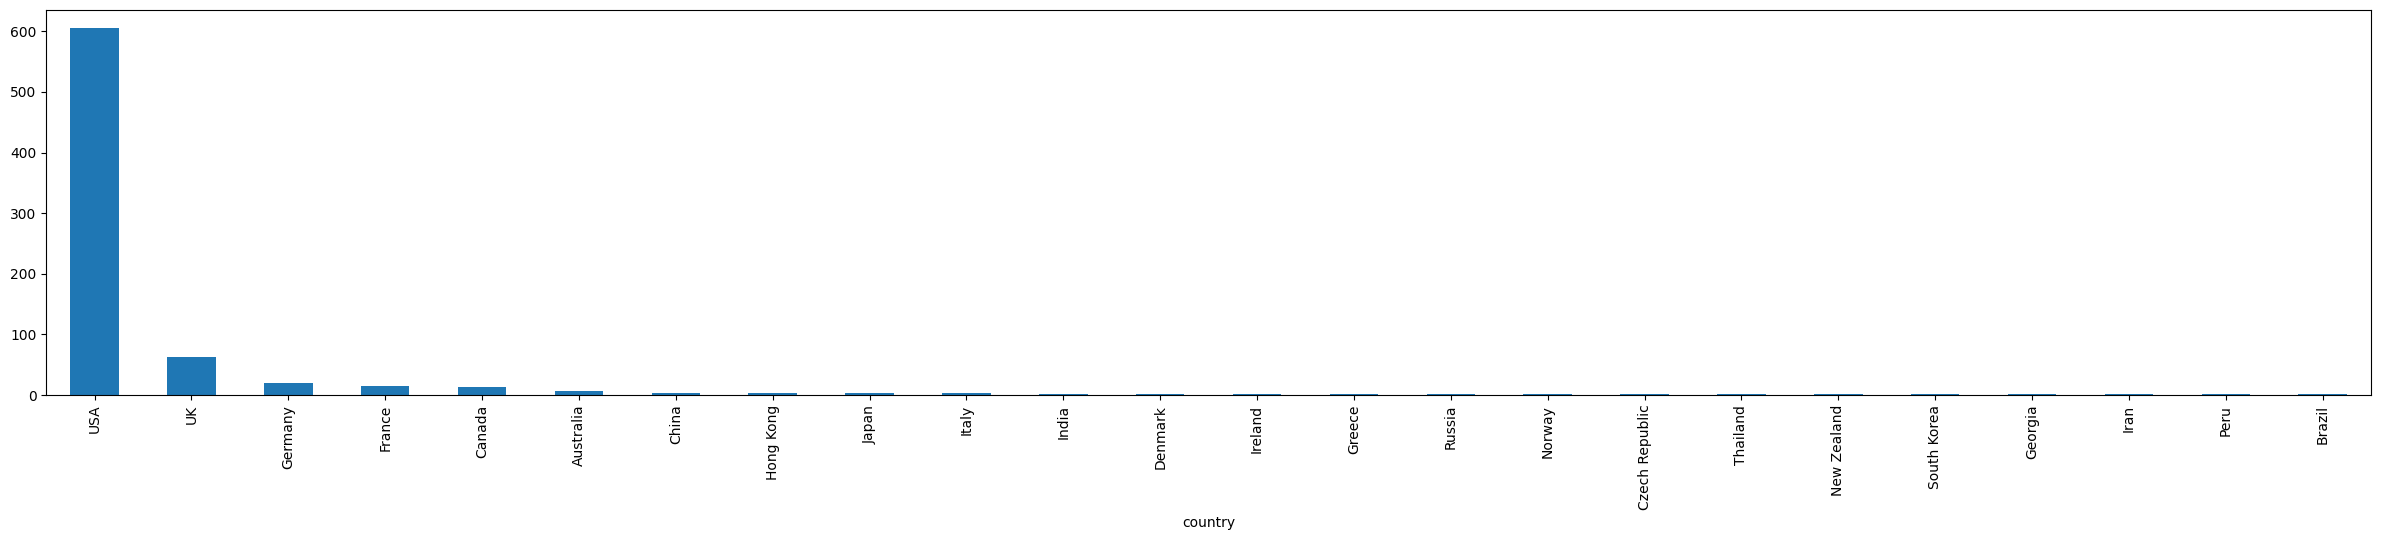

In [47]:
test_set['country'].value_counts()

test_set['country'].value_counts().plot(kind = 'bar', figsize=(30,5))
plt.show()

In [48]:
test_set = pd.concat([pd.get_dummies(test_set['country'])[['USA','UK','Germany','France']].astype(int), test_set.drop('country', axis = 1)], axis = 1)
test_set

,USA,UK,Germany,France,R,PG-13,PG,G,Biography,Drama,...,actor_2_name,gross,actor_1_name,movie_title,num_voted_users,actor_3_name,num_user_for_reviews,title_year,movie_facebook_likes,average_degree_centrality
0,1,0,0,0,0,0,1,0,1,1,...,Finn Wittrock,2246000,Donny Boaz,Courage,2302,Brent Anderson,20,2015,0,0.000375
1,1,0,0,0,1,0,0,0,0,1,...,Shea Whigham,47307550,Demián Bichir,Savages,104301,Gary Stretch,269,2012,28000,0.002176
2,0,0,0,0,1,0,0,0,0,1,...,Tony Nappo,37606,Michael Kelly,Defendor,31836,Charlotte Sullivan,90,2009,0,0.000900
3,1,0,0,0,1,0,0,0,0,1,...,Jennifer Jason Leigh,104054514,Tom Hanks,Road to Perdition,200359,Liam Aiken,1009,2002,0,0.003452
4,1,0,0,0,1,0,0,0,0,0,...,Alia Shawkat,3447339,Donald Glover,The To Do List,29517,Scott Porter,79,2013,0,0.000450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,1,0,0,0,1,0,0,0,0,1,...,Connie Nielsen,17096053,Bill Murray,Rushmore,134458,Olivia Williams,640,1998,5000,0.002777
748,1,0,0,0,1,0,0,0,0,0,...,Dominic Cooper,37516013,Rufus Sewell,Abraham Lincoln: Vampire Hunter,128629,Benjamin Walker,348,2012,98000,0.001801
749,0,1,0,0,0,0,0,0,0,1,...,Rupert Graves,20966644,Julian Sands,A Room with a View,29610,Denholm Elliott,94,1985,0,0.001126
750,1,0,0,0,0,0,0,1,0,0,...,Phil Collins,47887943,Haley Joel Osment,The Jungle Book 2,11634,Tony Jay,58,2003,227,0.000825


### Other categorical columns (director_name, actor_1_name, actor_2_name, actor_3_name, movie_title)

In [49]:
test_set.drop(columns = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'movie_title'], inplace = True )
test_set.columns

Index(['USA', 'UK', 'Germany', 'France', 'R', 'PG-13', 'PG', 'G', 'Biography',
       'Drama', 'History', 'Sport', 'Crime', 'Animation', 'Comedy', 'Sci-Fi',
       'Fantasy', 'Mystery', 'Thriller', 'Romance', 'Music', 'Horror',
       'Western', 'Documentary', 'Action', 'Musical', 'Adventure', 'Family',
       'War', 'num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'gross', 'num_voted_users', 'num_user_for_reviews', 'title_year',
       'movie_facebook_likes', 'average_degree_centrality'],
      dtype='object')

In [50]:
pd.Series(list(test_set.dtypes)).unique() # Check if there's any object column left

array([dtype('int64'), dtype('float64')], dtype=object)

## Inspect missing value
No missing value

In [51]:
test_set.isna().sum()

USA                          0
UK                           0
Germany                      0
France                       0
R                            0
PG-13                        0
PG                           0
G                            0
Biography                    0
Drama                        0
History                      0
Sport                        0
Crime                        0
Animation                    0
Comedy                       0
Sci-Fi                       0
Fantasy                      0
Mystery                      0
Thriller                     0
Romance                      0
Music                        0
Horror                       0
Western                      0
Documentary                  0
Action                       0
Musical                      0
Adventure                    0
Family                       0
War                          0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
gross   

## Standardise

In [52]:
scaler_test = joblib.load('standardise_scaler.pkl') 
X_test = test_set
X_test = pd.DataFrame(scaler_test.fit_transform(X_test), columns=X_test.columns)

## Obtain new set from the selected feature

In [53]:
new_test_set = X_test[selected_features_scaled] # Use features selected from training 
new_test_set

,USA,Germany,R,PG-13,Drama,Biography,History,Animation,Sci-Fi,Comedy,...,Adventure,Family,War,num_critic_for_reviews,duration,gross,num_voted_users,num_user_for_reviews,title_year,movie_facebook_likes
0,0.492925,-0.161,-0.903562,-0.746281,0.968579,3.963724,-0.181568,-0.266880,-0.409514,-0.783412,...,-0.538405,-0.364047,-0.18544,-1.120187,0.276693,-0.688430,-0.684685,-0.811727,1.248290,-0.404510
1,0.492925,-0.161,1.106730,-0.746281,0.968579,-0.252288,-0.181568,-0.266880,-0.409514,-0.783412,...,-0.538405,-0.364047,-0.18544,1.250169,1.183587,-0.106462,-0.033339,-0.181126,0.915413,0.636661
2,-2.028706,-0.161,1.106730,-0.746281,0.968579,-0.252288,-0.181568,-0.266880,-0.409514,1.276468,...,-0.538405,-0.364047,-0.18544,-0.732725,-0.630201,-0.716951,-0.496087,-0.634449,0.582535,-0.404510
3,0.492925,-0.161,1.106730,-0.746281,0.968579,-0.252288,-0.181568,-0.266880,-0.409514,-0.783412,...,-0.538405,-0.364047,-0.18544,0.391675,0.237263,0.626421,0.580069,1.692946,-0.194178,-0.404510
4,0.492925,-0.161,1.106730,-0.746281,-1.032441,-0.252288,-0.181568,-0.266880,-0.409514,1.276468,...,-0.538405,-0.364047,-0.18544,-0.588376,-0.275330,-0.672914,-0.510895,-0.662307,1.026372,-0.404510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0.492925,-0.161,1.106730,-0.746281,0.968579,-0.252288,-0.181568,-0.266880,-0.409514,1.276468,...,-0.538405,-0.364047,-0.18544,0.034602,-0.709061,-0.496642,0.159238,0.758442,-0.638015,-0.218586
748,0.492925,-0.161,1.106730,-0.746281,-1.032441,-0.252288,-0.181568,-0.266880,-0.409514,-0.783412,...,-0.538405,-0.364047,-0.18544,1.660423,-0.235899,-0.232920,0.122015,0.018943,0.915413,3.239589
749,-2.028706,-0.161,-0.903562,-0.746281,0.968579,-0.252288,-0.181568,-0.266880,-0.409514,-0.783412,...,-0.538405,-0.364047,-0.18544,-0.907463,0.237263,-0.446654,-0.510301,-0.624319,-2.080483,-0.404510
750,0.492925,-0.161,-0.903562,-0.746281,-1.032441,-0.252288,-0.181568,3.746999,-0.409514,-0.783412,...,1.857338,2.746899,-0.18544,-0.679544,-1.537095,-0.098967,-0.625093,-0.715490,-0.083219,-0.396069


## Apply KNN Classifier

In [54]:
knn = joblib.load("knn.pkl")
y_test_pred_knn = knn.predict(new_test_set)
df_knn = pd.DataFrame({
    'id': test_id,
    'imdb_score_binned': y_test_pred_knn
})

In [55]:
df_knn.to_csv('predicted_scores.csv', index=False)

## Apply Random Forest Trained Classifier

In [63]:
randomforest = joblib.load("randomforest.pkl")
y_test_pred_rf = randomforest.predict(new_test_set)
df_rf = pd.DataFrame({
    'id': test_id,
    'imdb_score_binned': y_test_pred_rf
})

In [64]:
# Export the DataFrame to a CSV file to submit on Kaggle
df_rf.to_csv('predicted_scores2.csv', index=False)